In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.cluster import *

In [2]:
data_set = pd.read_csv('/home/mytrah-pc/Mytrah_Adithya/data_turbine/ScatterData_Mokal_MK014.csv')
data_set.drop_duplicates(subset=['ActivePower', 'WindSpeed'], keep=False)

,Timestamp,WindSpeed,ActivePower,TurbineState,RotorSpeed,WindDirection
0,2017-05-22T09:50:00,9.271279,-1.942419,21.000000,0.024667,-5.409583
1,2017-05-22T10:00:00,10.022556,-2.103000,50.933333,0.015667,-0.315317
2,2017-05-22T10:10:00,9.754348,276.429508,13.983333,5.322000,0.520517
3,2017-05-22T10:20:00,11.039119,1575.982809,85.916667,15.453000,1.827650
4,2017-05-22T10:30:00,8.795947,945.183811,11.000000,15.326333,6.782717
5,2017-05-22T10:40:00,7.682036,623.005589,11.000000,15.267667,8.487033
6,2017-05-22T10:50:00,8.766295,925.394641,11.000000,15.325000,-1.589417
7,2017-05-22T11:00:00,8.310630,801.825948,70.933333,15.301500,7.373600
8,2017-05-22T11:10:00,7.355721,587.333879,11.000000,15.236167,-2.765583
9,2017-05-22T11:20:00,6.944432,503.912105,11.000000,15.234000,1.129333


In [3]:
def process_dbscan(data_set, dict_params_dbscan, scale_factor_wind_speed=4.0/3, scale_factor_active_power=1):

    # Only take the required data, only positive power points
    required_data = data_set[data_set['ActivePower'] > 0.08][['ActivePower', 'WindSpeed', 'Timestamp']].copy()

    # Get some params
    max_wind_speed = required_data['WindSpeed'].max()
    min_wind_speed = required_data['WindSpeed'].min()
    max_active_power = required_data['ActivePower'].max()
    min_active_power = required_data['ActivePower'].min()
    normalization_factor_wind_speed = max_wind_speed - min_wind_speed
    normalization_factor_active_power = max_active_power - min_active_power

    # Add some columns to required data
    required_data['ScaledWindSpeed'] = ((required_data['WindSpeed'] - min_wind_speed) * scale_factor_wind_speed) \
                                        / normalization_factor_wind_speed
    required_data['ScaledActivePower'] = ((required_data['ActivePower'] - min_active_power) * scale_factor_active_power) \
                                        / normalization_factor_active_power
    
    # Cluster default Number
    required_data['cluster_number'] = -2
    
    # Clustring Algorithm
    clustering_algorithm = DBSCAN(**dict_params_dbscan)
    
    # run the algorithm
    required_data['cluster_number'] = clustering_algorithm.fit_predict(required_data[['ScaledWindSpeed', \
                                                                                      'ScaledActivePower']])

    return required_data.copy()
    
def curve_filter(data_set, return_columns, push_down_value, curve_straighten_value, push_right_value):

    # Find the cluster with max number of elements
    max_elements_cluster_number = -2
    max_elements = 0
    for group in data_set.groupby('cluster_number'):
        if(group[1].shape[0] > max_elements):
            max_elements = group[1].shape[0]
            max_elements_cluster_number = group[0]

    
    # define limits
    scales_active_power_limits = (0.03, 0.97)
    
    # Apply some filters to get the required
    global_high_cluster = data_set[data_set['ScaledActivePower'] > 0.99]   
    max_elements_cluster = data_set[data_set['cluster_number'] == max_elements_cluster_number]
    filter_limits_active_power = max_elements_cluster[ \
                                    (max_elements_cluster['ScaledActivePower'] > scales_active_power_limits[0]) \
                                     & (max_elements_cluster['ScaledActivePower'] < scales_active_power_limits[1])]


    # Customised Sigmoid function for curve fitting
    def custom_sigmoid(x, a, b):
        return 1/(1 + np.exp(-a * x + b))
    
    optimize_on = pd.concat([filter_limits_active_power, global_high_cluster])
    
    params_optimal, params_covariance = curve_fit(custom_sigmoid, optimize_on['ScaledWindSpeed'], \
                                                  optimize_on['ScaledActivePower'])
    
    ################################### Filter elements below the Curve ############################
    filtered_data = data_set[data_set['ScaledActivePower'] > (custom_sigmoid(data_set['ScaledWindSpeed'], \
                                                                        params_optimal[0] + curve_straighten_value, \
                                                                        params_optimal[1] + push_right_value) \
                                                                        - push_down_value)]
    
    points_above_the_curve = filtered_data[return_columns].copy()
    
    return points_above_the_curve


In [4]:
points_above_curve = curve_filter(
    process_dbscan(
        data_set=data_set,
        dict_params_dbscan={
            'eps': 0.3/20,
            'min_samples': 15
        },
        scale_factor_wind_speed=4.0/3,
        scale_factor_active_power=1
    ),
    return_columns=['ActivePower', 'WindSpeed', 'Timestamp', 'ScaledActivePower'],
    push_down_value=0.1,
    curve_straighten_value=0,
    push_right_value=1.3
)

work_data = points_above_curve[(points_above_curve['ScaledActivePower'] > 0.25) & (points_above_curve['ScaledActivePower'] < 0.85)].copy()

In [5]:
def rounding_method(number):
    multiply_factor = 100
    int_format = int(number * multiply_factor)
    round_off_by_factor = 2
    delta = int_format % round_off_by_factor
    return int_format + round_off_by_factor - delta

work_data['trend_indexer'] = work_data['ScaledActivePower'].apply(rounding_method)

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import norm

In [7]:
# hist = None
# mid = -10
# tot_scr = 0
# tot_ex = 0
# for group in work_data.groupby('trend_indexer'):
#     plt.hist(group[1]['WindSpeed'])
#     plt.show()
#     hist = np.histogram(group[1]['WindSpeed'])
#     mid = 0
#     score = 0
#     for i in range(hist[0].shape[0]):
#         mid = mid + hist[0][i] * ((hist[1][i] + hist[1][i + 1]) / 2)
#     print (mid / hist[0].sum())
#     for i in range(hist[0].shape[0]):
#         score = score + norm((mid / hist[0].sum()), 1).pdf((hist[1][i] + hist[1][i + 1]) / 2) * hist[0][i]
#     print score / hist[0].sum()
#     tot_scr = tot_scr + (score / hist[0].sum())
#     tot_ex = tot_ex + 1
#     plt.figure(figsize=(20, 10))
#     plt.scatter(work_data['WindSpeed'], work_data['trend_indexer'])
#     plt.scatter(group[1]['WindSpeed'], [group[0] for _ in range(group[1].shape[0])])
#     plt.show()

# print '-------------------------------------------------------------------------------------------'
# print tot_scr / tot_ex

In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.cluster import *

def process_dbscan(data_set, dict_params_dbscan, scale_factor_wind_speed=4.0/3, scale_factor_active_power=1):

    # Only take the required data, only positive power points
    required_data = data_set[data_set['ActivePower'] > 0.08][['ActivePower', 'WindSpeed', 'Timestamp']].copy()

    # Get some params
    max_wind_speed = required_data['WindSpeed'].max()
    min_wind_speed = required_data['WindSpeed'].min()
    max_active_power = required_data['ActivePower'].max()
    min_active_power = required_data['ActivePower'].min()
    normalization_factor_wind_speed = max_wind_speed - min_wind_speed
    normalization_factor_active_power = max_active_power - min_active_power

    # Add some columns to required data
    required_data['ScaledWindSpeed'] = ((required_data['WindSpeed'] - min_wind_speed) * scale_factor_wind_speed) \
                                        / normalization_factor_wind_speed
    required_data['ScaledActivePower'] = ((required_data['ActivePower'] - min_active_power) * scale_factor_active_power) \
                                        / normalization_factor_active_power
    
    # Cluster default Number
    required_data['cluster_number'] = -2
    
    # Clustring Algorithm
    clustering_algorithm = DBSCAN(**dict_params_dbscan)
    
    # run the algorithm
    required_data['cluster_number'] = clustering_algorithm.fit_predict(required_data[['ScaledWindSpeed', \
                                                                                      'ScaledActivePower']])

    return required_data.copy()

def curve_filter(data_set, return_columns, push_down_value, curve_straighten_value, push_right_value):

    # Find the cluster with max number of elements
    max_elements_cluster_number = -2
    max_elements = 0
    for group in data_set.groupby('cluster_number'):
        if(group[1].shape[0] > max_elements):
            max_elements = group[1].shape[0]
            max_elements_cluster_number = group[0]

    
    # define limits
    scales_active_power_limits = (0.03, 0.97)
    
    # Apply some filters to get the required
    global_high_cluster = data_set[data_set['ScaledActivePower'] > 0.99]   
    max_elements_cluster = data_set[data_set['cluster_number'] == max_elements_cluster_number]
    filter_limits_active_power = max_elements_cluster[ \
                                    (max_elements_cluster['ScaledActivePower'] > scales_active_power_limits[0]) \
                                     & (max_elements_cluster['ScaledActivePower'] < scales_active_power_limits[1])]


    # Customised Sigmoid function for curve fitting
    def custom_sigmoid(x, a, b):
        return 1/(1 + np.exp(-a * x + b))
    
    optimize_on = pd.concat([filter_limits_active_power, global_high_cluster])
    
    params_optimal, params_covariance = curve_fit(custom_sigmoid, optimize_on['ScaledWindSpeed'], \
                                                  optimize_on['ScaledActivePower'])
    
    ################################### Filter elements below the Curve ############################
    filtered_data = data_set[data_set['ScaledActivePower'] > (custom_sigmoid(data_set['ScaledWindSpeed'], \
                                                                        params_optimal[0] + curve_straighten_value, \
                                                                        params_optimal[1] + push_right_value) \
                                                                        - push_down_value)]
    
    points_below_the_curve = filtered_data[return_columns].copy()
    
    return points_below_the_curve

[ 10.45650823   4.9450078 ] [[ 0.06336389  0.02959166]
 [ 0.02959166  0.01406382]]
[ 8.32483076  4.01063887] [[ 0.2351091   0.11961417]
 [ 0.11961417  0.06229022]]
[ 4.7523912   3.00343625] [[ 0.08221345  0.03445612]
 [ 0.03445612  0.0150458 ]]
[ 11.3439359    5.44596053] [[ 0.16463997  0.07429167]
 [ 0.07429167  0.03516967]]
[ 10.85744651   5.22633429] [[ 0.03459123  0.01501818]
 [ 0.01501818  0.00682448]]
[ 11.53762887   5.56485422] [[ 0.17958871  0.09163495]
 [ 0.09163495  0.04924319]]
[ 11.1639881    5.23798652] [[ 0.5716125   0.32968449]
 [ 0.32968449  0.19697498]]
[ 10.62558165   5.09342459] [[ 0.02235258  0.01027766]
 [ 0.01027766  0.0048525 ]]
[ 9.11858867  4.58361059] [[ 0.25616464  0.09919881]
 [ 0.09919881  0.04124537]]
[ 8.97497137  4.54753785] [[ 0.14155917  0.06959361]
 [ 0.06959361  0.03605621]]
[ 7.72282797  3.78429883] [[ 0.14442665  0.07259934]
 [ 0.07259934  0.03712446]]
[ 3.51161685  1.69655482] [[ 0.41646572  0.24159998]
 [ 0.24159998  0.14269556]]
[ 7.16467048  3.

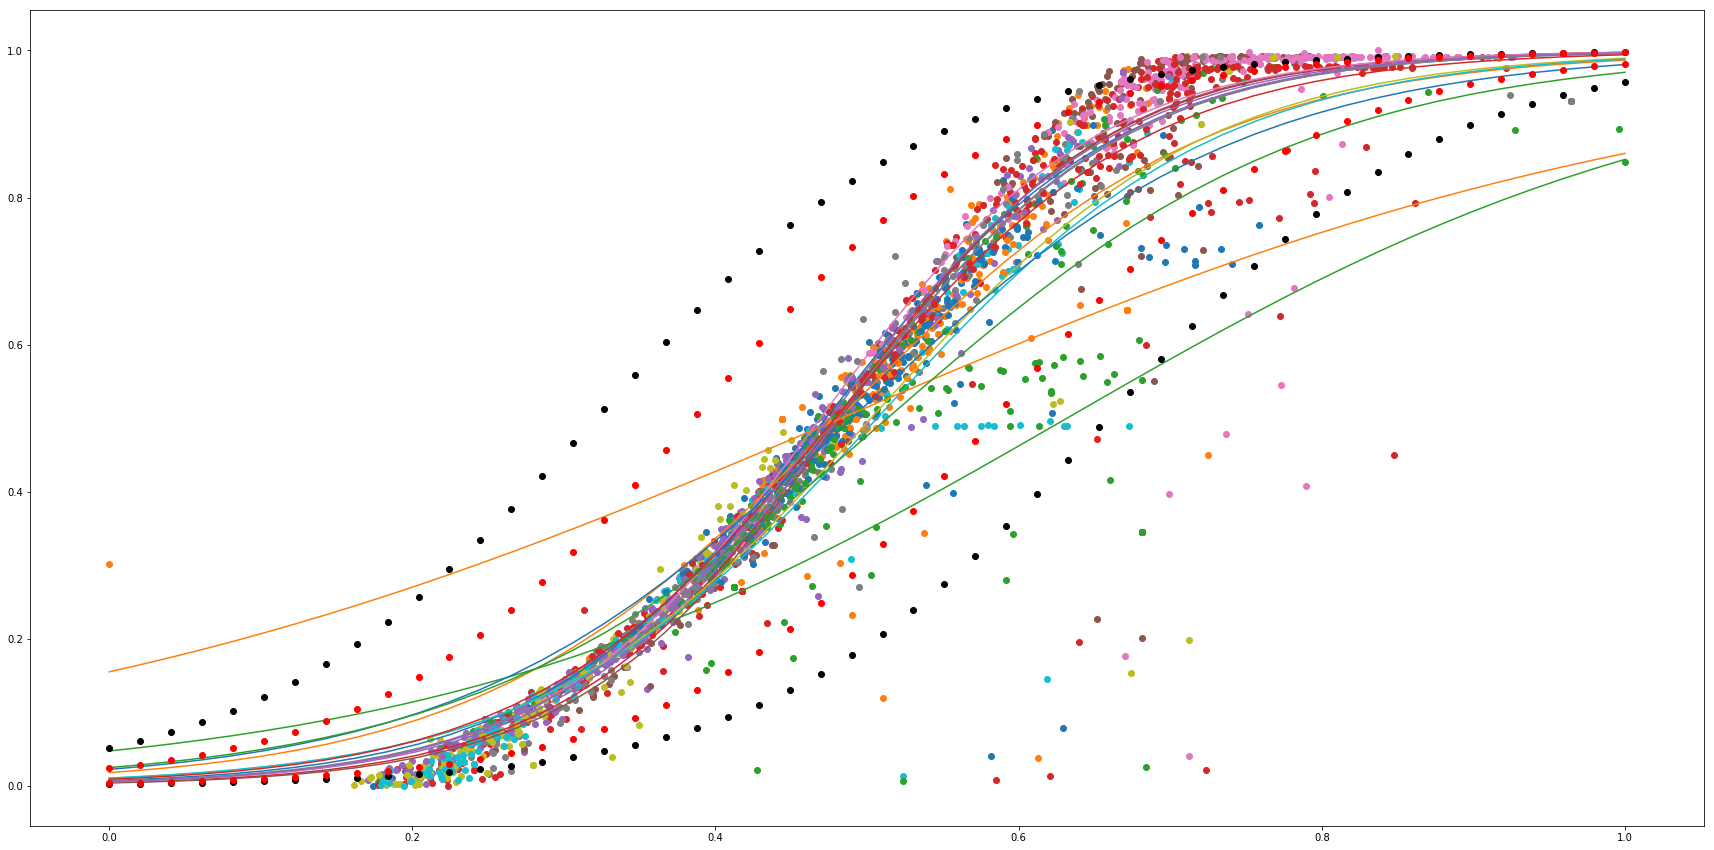

[ 8.55164534  3.45534924] [[ 0.10697832  0.04449676]
 [ 0.04449676  0.01941019]]
[ 10.35616197   4.34817722] [[ 0.17990042  0.07823218]
 [ 0.07823218  0.03503371]]
[ 9.91228276  3.85123988] [[ 0.02066605  0.00615964]
 [ 0.00615964  0.00186031]]
[ 9.88348214  3.96407205] [[ 0.08164013  0.02964443]
 [ 0.02964443  0.0120088 ]]
[ 8.75015844  3.59071642] [[ 0.02796445  0.01007264]
 [ 0.01007264  0.00387639]]
[ 8.49427176  3.5726276 ] [[ 0.31799807  0.16588044]
 [ 0.16588044  0.09410319]]
[ 10.38852409   4.17892622] [[ 0.26876859  0.12945977]
 [ 0.12945977  0.06568309]]
[ 9.16253208  3.69327942] [[ 0.02118699  0.00802178]
 [ 0.00802178  0.00321688]]
[ 8.66244452  3.58207948] [[ 0.16650724  0.05011399]
 [ 0.05011399  0.01716672]]
[ 8.93636113  3.72599344] [[ 0.04499565  0.01970464]
 [ 0.01970464  0.00916996]]
[ 7.63543997  3.14880878] [[ 0.14955716  0.0686597 ]
 [ 0.0686597   0.0321852 ]]
[ 7.70419202  3.44150489] [[ 0.55506669  0.28414012]
 [ 0.28414012  0.15251732]]
[ 6.65226944  2.95330548

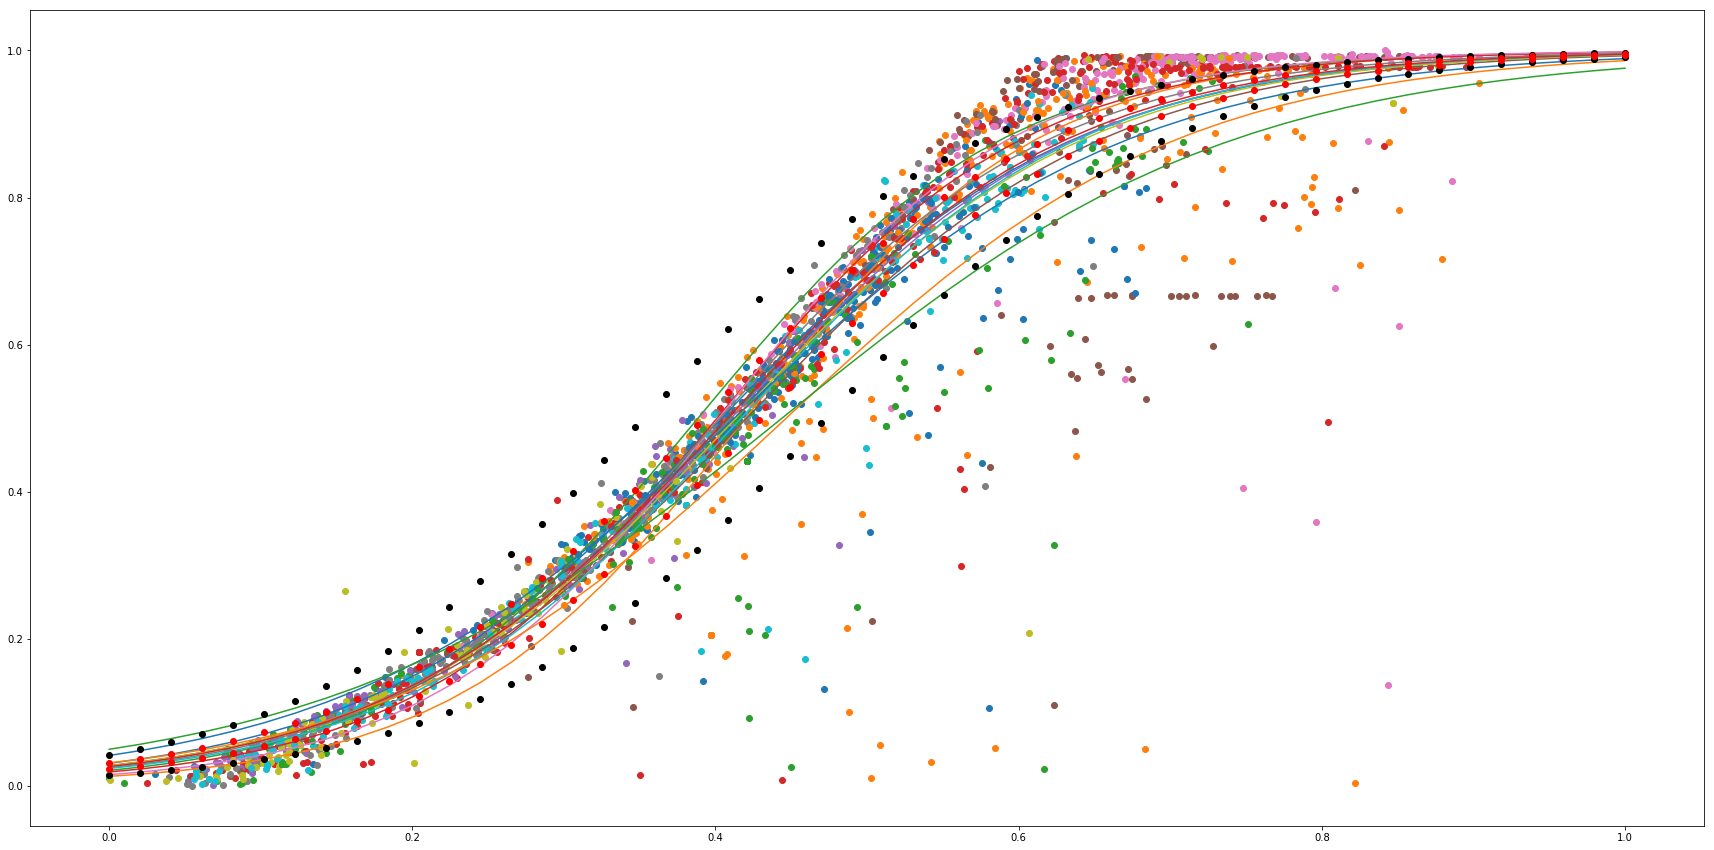

[ 13.8404106    5.57098127] [[ 0.03444511  0.01236575]
 [ 0.01236575  0.00458407]]
[ 13.99323253   5.67222148] [[ 0.09470548  0.03989416]
 [ 0.03989416  0.0170492 ]]
[ 13.87048044   5.64571303] [[ 0.17190557  0.0691473 ]
 [ 0.0691473   0.02934131]]
[ 14.67868122   5.8653595 ] [[ 0.10995806  0.04298417]
 [ 0.04298417  0.01741456]]
[ 14.44591496   5.76602356] [[ 0.08844271  0.03078791]
 [ 0.03078791  0.01090434]]
[ 7.76923663  3.20334308] [[ 0.25809736  0.12667781]
 [ 0.12667781  0.06493169]]
[-1.91263664 -1.73226584] [[ 0.56032146  0.33171979]
 [ 0.33171979  0.19937184]]
[ 13.46900063   5.44100759] [[ 0.02934604  0.01056393]
 [ 0.01056393  0.00392195]]
[ 1.02134966  1.36537774] [[ 0.221926    0.09120698]
 [ 0.09120698  0.04616373]]
[ 13.3304861    5.48916152] [[ 0.33922196  0.13844464]
 [ 0.13844464  0.05782742]]
[ 13.36987414   5.69063788] [[ 0.81352083  0.34688383]
 [ 0.34688383  0.14963901]]
[ 13.8264934    5.82719122] [[ 1.77314805  0.79993164]
 [ 0.79993164  0.36702034]]
[ 13.07553

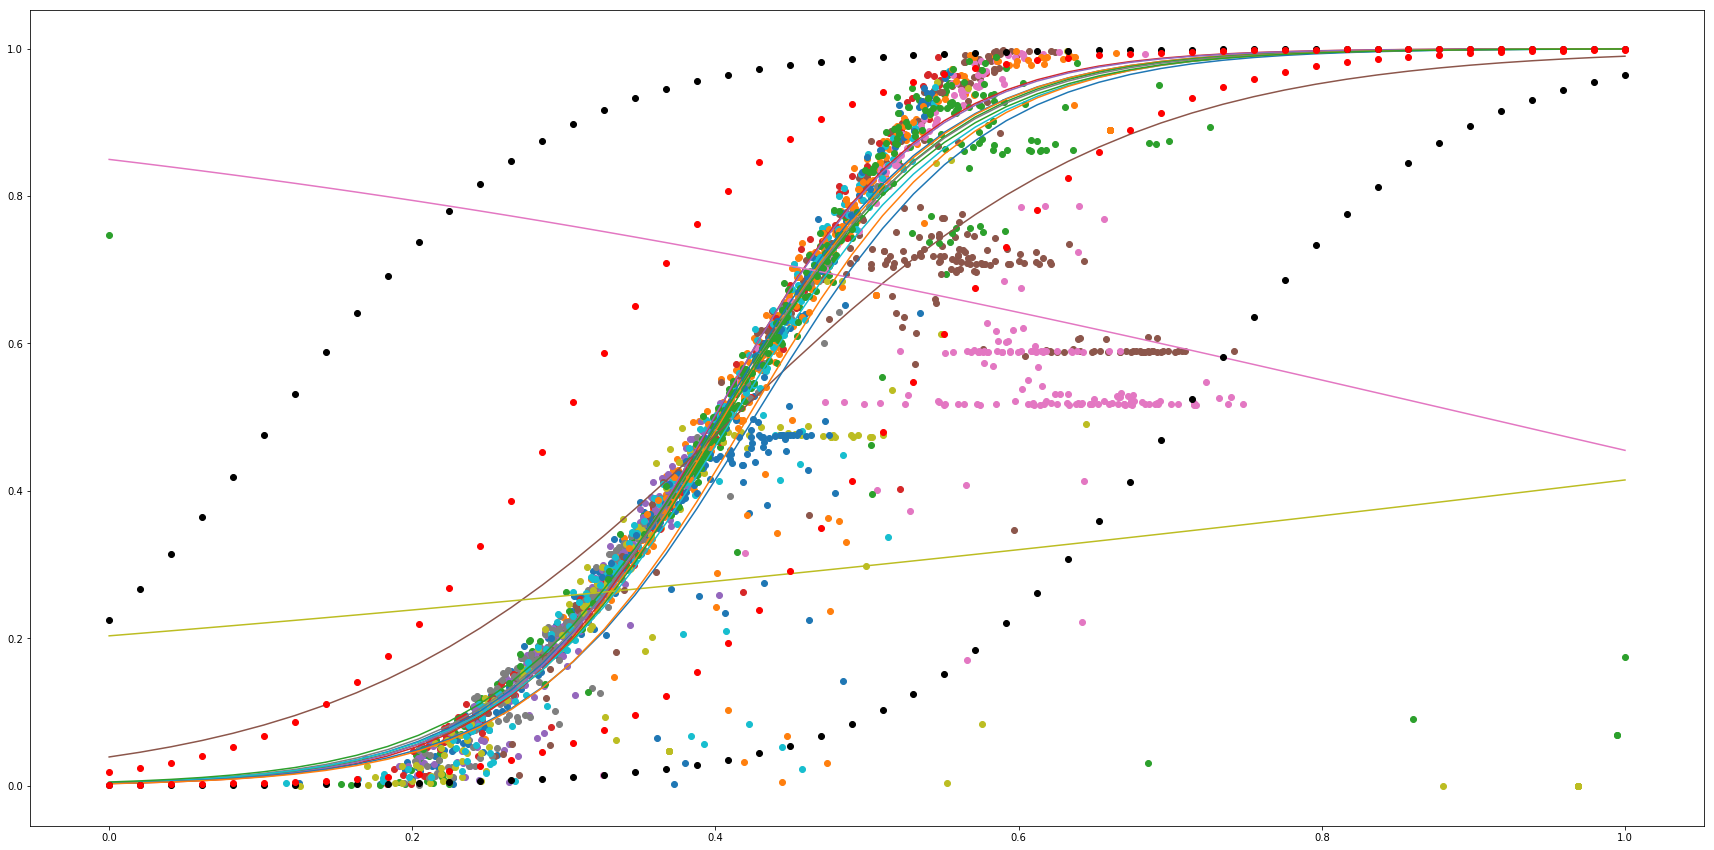

[ 10.28498877   3.67955375] [[ 0.1193666   0.02900403]
 [ 0.02900403  0.00794232]]
[ 10.95688164   3.87628507] [[ 0.03993009  0.01206158]
 [ 0.01206158  0.00394867]]
[ 11.2832836    3.98882147] [[ 0.06923183  0.02582701]
 [ 0.02582701  0.0098996 ]]
[ 10.07267596   3.55941173] [[ 0.16336363  0.06230726]
 [ 0.06230726  0.02523781]]
[ 11.47405641   3.94952995] [[ 0.02512648  0.00721497]
 [ 0.00721497  0.00218282]]
[ 7.92077615  2.93926257] [[ 0.17561587  0.07820065]
 [ 0.07820065  0.03740051]]
[ 0.50017843 -0.05279595] [[ 0.15721494  0.09245597]
 [ 0.09245597  0.05625338]]
[ 9.95420375  3.5814    ] [[ 0.02984699  0.00945862]
 [ 0.00945862  0.00320839]]
[ 7.94039348  3.19165269] [[ 0.12343833  0.04248685]
 [ 0.04248685  0.01640282]]
[ 9.61440884  3.55743957] [[ 0.27686958  0.08845233]
 [ 0.08845233  0.0299825 ]]
[ 12.45603884   4.76757923] [[ 0.60180603  0.24139451]
 [ 0.24139451  0.09834327]]
[ 13.01813407   4.97338671] [[ 2.38093224  1.03198399]
 [ 1.03198399  0.45482935]]
ScatterData_Mo

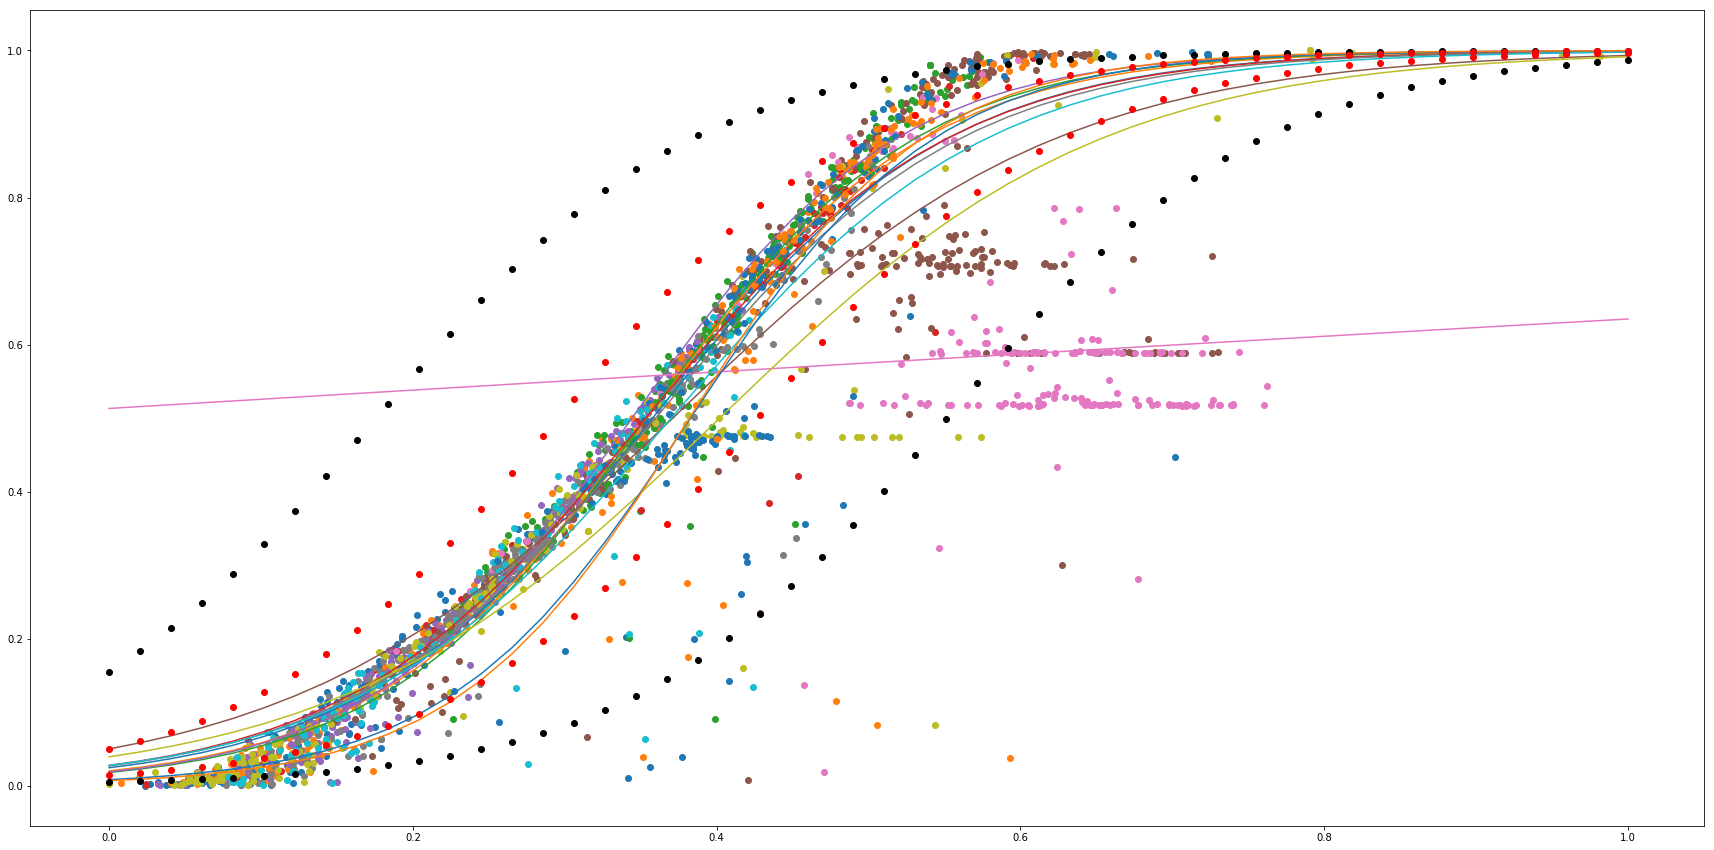

[ 14.2922067    4.40082866] [[ 1.93986102  0.75389411]
 [ 0.75389411  0.29735117]]
[ 12.47025069   3.65889491] [[ 0.18609449  0.0340882 ]
 [ 0.0340882   0.0067051 ]]
[ 11.81423129   3.4379918 ] [[ 0.04851762  0.01193255]
 [ 0.01193255  0.00334897]]
[ 13.26456196   3.6919202 ] [[ 1.23225761  0.25814449]
 [ 0.25814449  0.0580635 ]]
[ 20.13178644   9.10803218] [[ 19.0723184    9.70580479]
 [  9.70580479   4.97512286]]
[ 11.67389536   3.57456742] [[ 0.68823408  0.16777907]
 [ 0.16777907  0.0430318 ]]
[ 10.03542912   3.2067844 ] [[ 0.5828839   0.10586678]
 [ 0.10586678  0.02143199]]
[ 3.69980575 -1.00593093] [[ 23.49978817  12.30327186]
 [ 12.30327186   6.59688116]]
[ 14.95360346   4.52466143] [[ 12.34805164   4.50565302]
 [  4.50565302   1.70908058]]
[ 22.94321897   7.46033107] [[ 6.07011699  2.11813379]
 [ 2.11813379  0.76088532]]
[ 15.82224238   4.43742833] [[ 0.1076315   0.02973657]
 [ 0.02973657  0.00903719]]
ScatterData_Nidhi_NDH-047.csv
[ True  True] [ True  True]
[ True  True] [ Tru

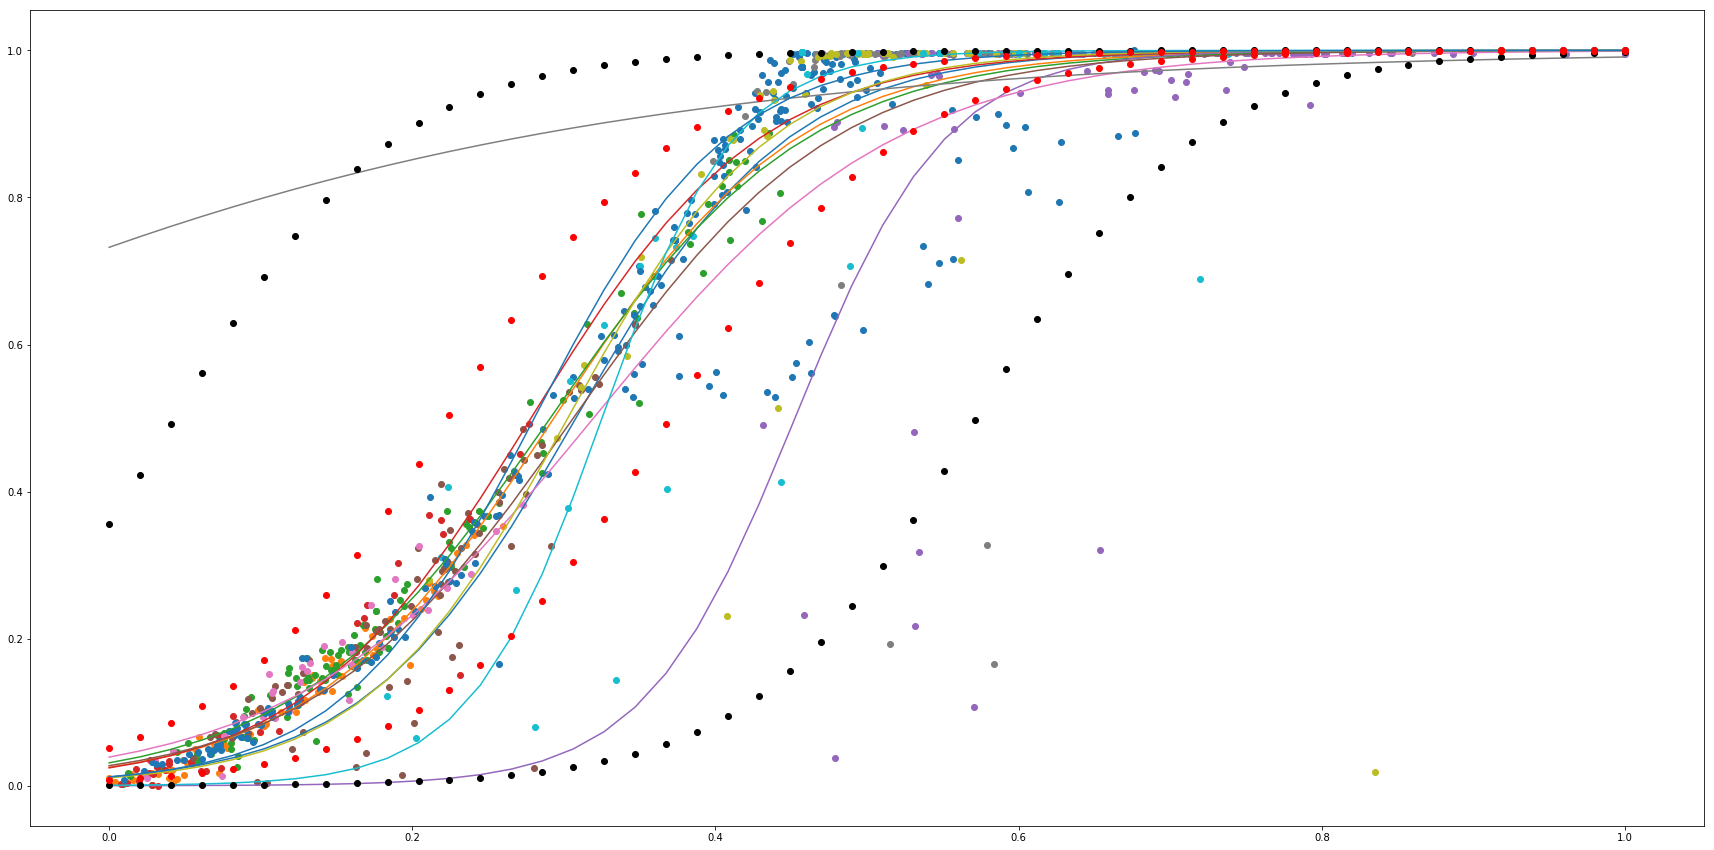

[ 7.40623016  4.60256222] [[ 0.0809663   0.0477274 ]
 [ 0.0477274   0.02892416]]
[ 7.95942158  4.83279063] [[ 0.07200112  0.04559426]
 [ 0.04559426  0.02933671]]
[ 8.53763914  5.13777882] [[ 0.04740007  0.03101935]
 [ 0.03101935  0.0210164 ]]
[ 10.5197373    6.14040583] [[ 0.1686295   0.1033499 ]
 [ 0.1033499   0.06445087]]
[ 8.13148322  4.85497162] [[ 0.03047528  0.01573325]
 [ 0.01573325  0.00843627]]
[ 8.19793939  4.82053672] [[ 0.04516327  0.02337605]
 [ 0.02337605  0.01253563]]
[ 8.73042939  5.31582121] [[ 0.05365738  0.02937875]
 [ 0.02937875  0.01662585]]
[ 7.96286124  4.854904  ] [[ 0.02528758  0.01295449]
 [ 0.01295449  0.00690323]]
[ 7.56295873  4.55622986] [[ 0.03048158  0.01796587]
 [ 0.01796587  0.01084885]]
[ 8.11430071  4.84950152] [[ 0.02955072  0.01805605]
 [ 0.01805605  0.01131182]]
[ 4.91498869  2.97727055] [[ 0.15654374  0.10268896]
 [ 0.10268896  0.06920299]]
ScatterData_Mahidad_JSD38.csv
[ True  True] [ True  True]
[ True  True] [ True  True]
[ True  True] [ True 

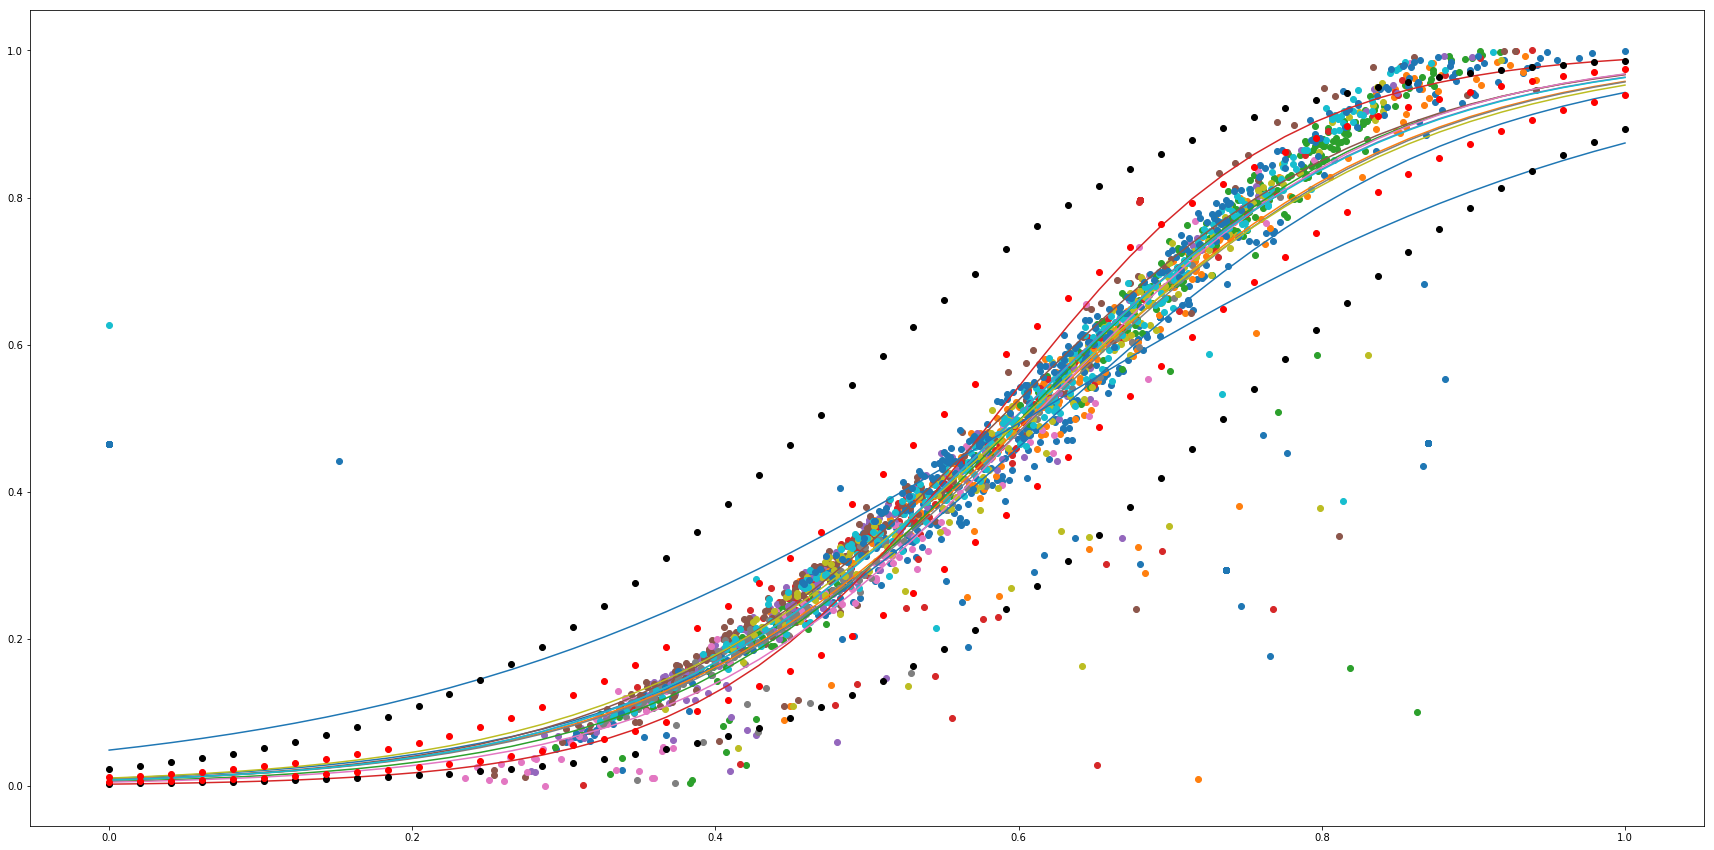

[ 1.93251589  1.16778525] [[ 0.17861662  0.10562594]
 [ 0.10562594  0.06414816]]
[ 10.6554984    5.39781084] [[ 0.13464338  0.06577957]
 [ 0.06577957  0.03317446]]
[ 11.01284584   5.54484264] [[ 0.10529025  0.04405682]
 [ 0.04405682  0.01902287]]
[ 10.75125548   5.38087158] [[ 0.0470996   0.02155764]
 [ 0.02155764  0.01020065]]
[ 9.15822017  4.69721266] [[ 0.1772622   0.08734606]
 [ 0.08734606  0.0440479 ]]
[ 9.28510435  4.84063721] [[ 0.12768783  0.06203422]
 [ 0.06203422  0.03066967]]
[ 2.85911114  1.4997465 ] [[ 0.10685668  0.05999852]
 [ 0.05999852  0.03450394]]
[ 6.03344407  3.1880812 ] [[ 0.09469206  0.05018356]
 [ 0.05018356  0.02757091]]
[ 9.99048602  5.08148983] [[ 0.03268866  0.01493347]
 [ 0.01493347  0.00692187]]
[ 10.59974642   5.40810062] [[ 0.06971404  0.03200946]
 [ 0.03200946  0.01500798]]
[ 10.97772879   5.55661396] [[ 0.03299239  0.01457346]
 [ 0.01457346  0.00657825]]
[ 4.74513097  2.67835224] [[ 0.08807561  0.04651204]
 [ 0.04651204  0.02507154]]
[ 1.37588809  1.12

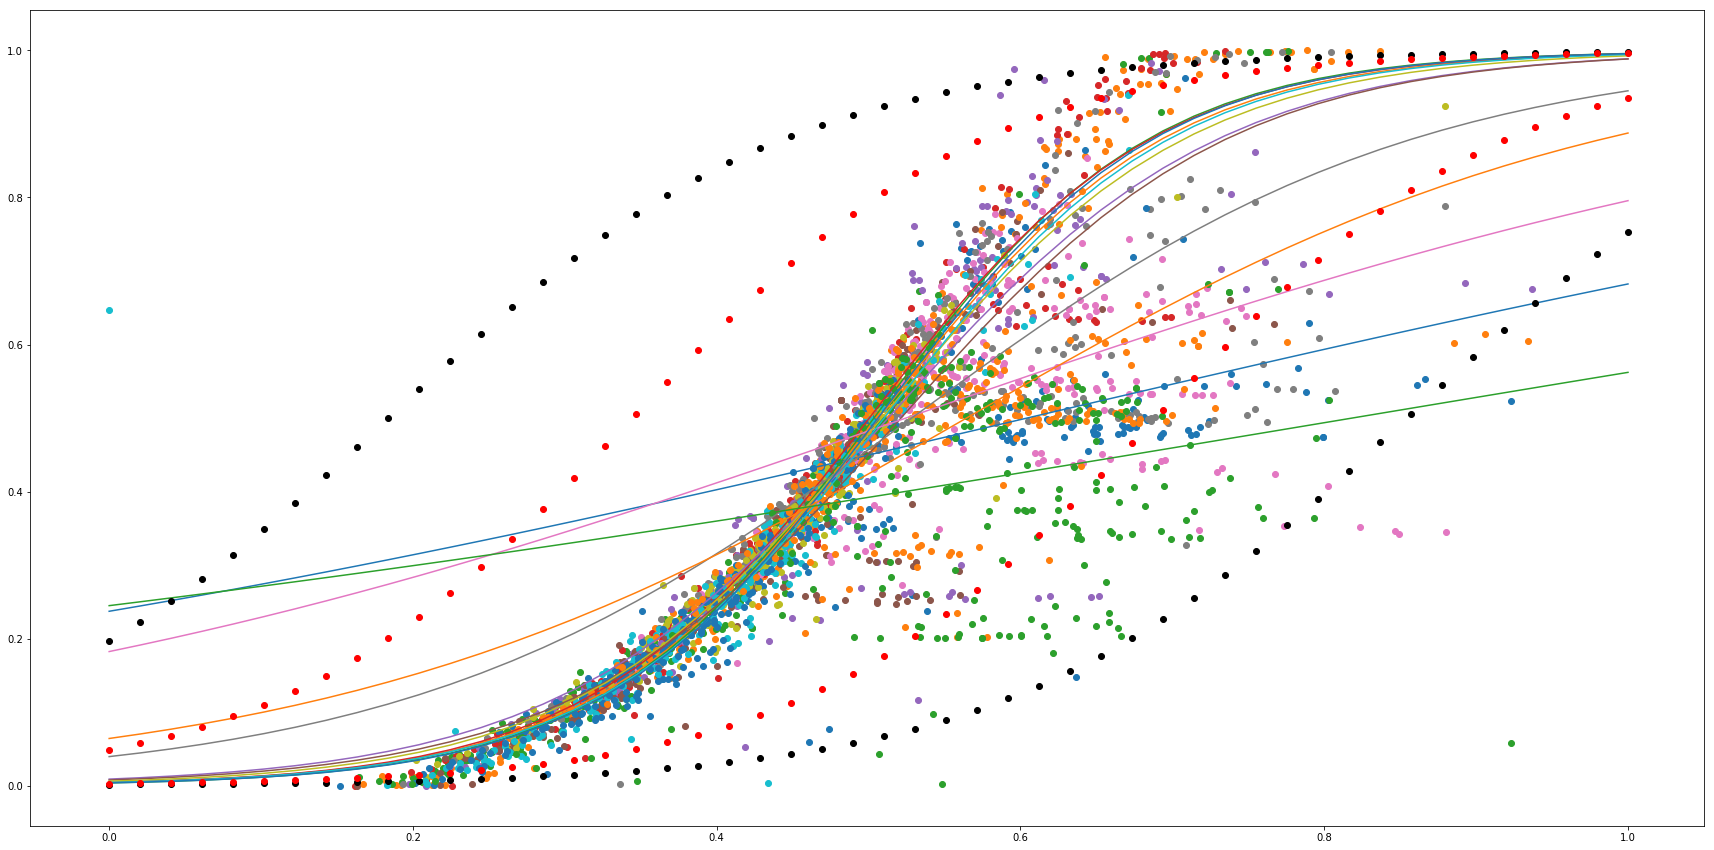

refcrv_testing.csv


/home/mytrah-pc/Mytrah_Adithya/env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mytrah-pc/Mytrah_Adithya/env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mytrah-pc/Mytrah_Adithya/env/local/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/mytrah-pc/Mytrah_Adithya/env/local/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mytrah-pc/Mytrah_Adithya/env/local/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: invalid index to scalar variable.

In [9]:
from datetime import timedelta, datetime


from os import listdir
from os.path import isfile, join

data_path = '/home/mytrah-pc/Mytrah_Adithya/data_turbine/'
for f in listdir(data_path):


    start = data_set['Timestamp'][0]
    time_obj = datetime.strptime(start, '%Y-%m-%dT%H:%M:%S') + timedelta(days=2)
    plus_day = time_obj.strftime('%Y-%m-%dT%H:%M:%S')

    def a_sig(x, a, b):
        return 1/(1 + np.exp(-a * x + b))

    plt.figure(figsize=(30, 15))

    data_set = pd.read_csv(data_path + f)

    testg = process_dbscan(
            data_set=data_set,
            dict_params_dbscan={
                'eps': 0.3/20,
                'min_samples': 13
            },
            scale_factor_wind_speed=4.0/3,
            scale_factor_active_power=1
        )
    max_wind_speed = testg['WindSpeed'].max()
    min_wind_speed = testg['WindSpeed'].min()
    max_active_power = testg['ActivePower'].max()
    min_active_power = testg['ActivePower'].min()
    normalization_factor_wind_speed = max_wind_speed - min_wind_speed
    normalization_factor_active_power = max_active_power - min_active_power

    testg['ScaledWindSpeed'] = ((testg['WindSpeed'] - min_wind_speed) * 1) \
                                            / normalization_factor_wind_speed
    testg['ScaledActivePower'] = ((testg['ActivePower'] - min_active_power) * 1) \
                                            / normalization_factor_active_power

    po = []
    while plus_day < testg['Timestamp'].iloc[-1]:
        test = testg[(testg['Timestamp'] > start) & (testg['Timestamp'] < plus_day)]

        start = plus_day
        time_obj = datetime.strptime(start, '%Y-%m-%dT%H:%M:%S') + timedelta(days=2)
        plus_day = time_obj.strftime('%Y-%m-%dT%H:%M:%S')

        if test.shape[0] < 30:
            continue
        else:
            pass


        params_optimal, params_covariance = curve_fit(a_sig, test['ScaledWindSpeed'], \
                                                      test['ScaledActivePower'])

        print params_optimal, params_covariance
        po.append(params_optimal)
        x = np.linspace(0, 1)
        y = a_sig(x, params_optimal[0], params_optimal[1])

        plt.plot(x, y)
        plt.scatter(test['ScaledWindSpeed'], test['ScaledActivePower'])

    print f
    mean_vals = np.mean(po, axis=0)
    std_vals = np.std(po, axis=0)

    cmp1 = mean_vals + 0.8 * std_vals
    cmp2 = mean_vals - 0.8 * std_vals
    new_pos = []
    
    for p in po:
        con1 = p < cmp1
        con2 = p > cmp2
        print con1, con2
        if con1[0] and con2[0] and con1[1] and con2[1]:
            new_pos.append(p)

    
    new_mean_vals = np.mean(new_pos, axis=0)
    new_std_vals = np.std(new_pos, axis=0)
    
    x = np.linspace(0, 1)
    y = a_sig(x, mean_vals[0], mean_vals[1] + 1.5 * std_vals[1])
    plt.plot(x, y, 'o', color='#000000')
    
    x = np.linspace(0, 1)
    y = a_sig(x, mean_vals[0], mean_vals[1] - 1.5 * std_vals[1])
    plt.plot(x, y, 'o', color='#000000')

    x = np.linspace(0, 1)
    y = a_sig(x, new_mean_vals[0], new_mean_vals[1] + 2 * new_std_vals[1])
    plt.plot(x, y, 'o', color='#FF0000')
    
    x = np.linspace(0, 1)
    y = a_sig(x, new_mean_vals[0], new_mean_vals[1] - 2 * new_std_vals[1])
    plt.plot(x, y, 'o', color='#FF0000')
    
    plt.show()